In [1]:
import gzip
import torch
import pandas as pd
from collections import defaultdict
import uuid
import numpy as np
from tqdm import tqdm
from torch.nn.functional import softmax, cross_entropy
import networkx as nx
import pickle
import torch.nn.functional as F


# Matrix Bulid

In [38]:
# write_to_disk = True
# ds_name = 
ds_name = "Theia" #Cadets, Theia

In [39]:
data_folder = f"dataset/{ds_name.lower()}/"
events_df = pd.read_csv(data_folder+f"{ds_name}_Krystal_transformation.csv")
seq_len = 10 # set seq len

In [40]:
set_name = "val" #train, val, test

fname_data_for_model = f"{ds_name}_{set_name}_data_for_model_one_hot_types.pkl"
fname_data_for_graph = f"{ds_name}_{set_name}_data_for_graph_one_hot_types.pkl"


val_data_for_model = pickle.load(open(data_folder+fname_data_for_model, "rb" ) )
val_data_for_graph = pickle.load(open(data_folder+fname_data_for_graph, "rb" ) )

In [41]:
set_name = "test" #train, val, test

fname_data_for_model = f"{ds_name}_{set_name}_data_for_model_one_hot_types.pkl"
fname_data_for_graph = f"{ds_name}_{set_name}_data_for_graph_one_hot_types.pkl"

test_data_for_model = pickle.load(open(data_folder+fname_data_for_model, "rb" ) )
test_data_for_graph = pickle.load(open(data_folder+fname_data_for_graph, "rb" ) )

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
print(f"{len(val_data_for_model['data_for_sequences'])} validation sequences")
print(f"{len(test_data_for_model['data_for_sequences'])} test sequences")


104 validation sequences
400 test sequences


# DeepLog

In [44]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Sampler
import numpy as np
from torch.utils.data import DataLoader

In [45]:
options = dict()
options['input_size'] =  46 #len(train_logs[0][0])
options['hidden_size'] = 16
options['num_layers'] = 2
options['num_classes'] = 6
options['batch_size'] = 64
options['p_dropout'] = 0.1
options['bidirectional'] = False
options['seq_len'] = 10

In [46]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class EncoderLSTM(nn.Module):
    def __init__(self, input_size=options['input_size'], hidden_size=options['hidden_size']):#p_dropout, bidirectional, num_layers, num_classes
        super(EncoderLSTM, self).__init__()
#         self.bidirectional = bidirectional
        self.hidden_size = input_size#hidden_size
        self.lstm = nn.GRU(input_size=input_size,
                            hidden_size=self.hidden_size,)

    def forward(self, one_log_event, hidden):
        output = one_log_event.view(1, 1, -1).float()#embedded #
#         print(one_log_event.shape, output.shape, hidden.shape)
        output, hidden = self.lstm(output, hidden)
#         for log in logs:
#             _, hid = self.lstm(log.float(), hid)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device) #1, num_layers, self.hidden_size
    
class AttnDecoderLSTM(nn.Module):
    def __init__(self, hidden_size=options['input_size'], output_size=options['num_classes'], 
                 dropout_p=options['p_dropout'], seg_length=options['seq_len']): #hidden_size=options['hidden_size']
        super(AttnDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.encoder_out_to_output_size = nn.Linear(self.hidden_size, output_size)
        self.attn = nn.Linear(hidden_size + output_size, seg_length)
        self.attn_combine = nn.Linear(hidden_size + output_size, hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.GRU(hidden_size, hidden_size)
        self.out1 = nn.Linear(hidden_size, hidden_size//2)

        self.out2 = nn.Linear(hidden_size//2, output_size)

    def forward(self, input, hidden, encoder_outputs):
        hidden = hidden.view(1, 1, -1)
        input_embedded = input.view(1, 1, -1)#
        attn_weights = F.softmax(
            self.attn(torch.cat((input_embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((input_embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out1(output[0])
        output = F.log_softmax(self.out2(output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [47]:
encoder = EncoderLSTM().to(device)
decoder = AttnDecoderLSTM().to(device)

In [48]:
# class log_dataset(Dataset):
#     def __init__(self, logs, labels):
#         self.logs = logs #['Sequentials']
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         log = torch.tensor(self.logs[idx], dtype=torch.long)
#         labels = torch.tensor(self.labels[idx], dtype=torch.long)
#         return log, labels

In [49]:
# fill model with the trained weights
# encoder_path = "2023-07-18 10 - encoder_model cadets and theia seq2seq1.pth"
# decoder_path = "2023-07-18 10 - decoder_model cadets and theia seq2seq1.pth"
encoder_path = "2023-07-21 20 - encoder_model cadets and theia seq2seq2.pth"
decoder_path = "2023-07-21 20 - decoder_model cadets and theia seq2seq2.pth"


encoder.load_state_dict(torch.load(encoder_path))
encoder = encoder.to(device)

# model_path = "agregator_model cadets and theia.pth"#"agregator_model.pth"
# model_path = "agregator_model - old.pth"
decoder.load_state_dict(torch.load(decoder_path))
decoder = decoder.to(device)

# Find anomaly threshold from validation set

In [50]:
encoder.eval()
decoder.eval()
SOS_tok = torch.zeros(1, options['num_classes'], device=device)

In [51]:
SOS_tok

tensor([[0., 0., 0., 0., 0., 0.]])

In [52]:
# anomaly_score_ls = []
mistakes_ls = []
candidates = 1


with torch.no_grad():

    for seq in tqdm(val_data_for_model['data_for_sequences']):
        ind = seq['seq_ind']
        logs_input = torch.tensor([seq['logs_for_sequence']], dtype=torch.long).to(device)
        next_event_types = torch.tensor(seq['next_event_types'], dtype=torch.long).long().to(device)
        
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(options['seq_len'], encoder.hidden_size, device=device)
        
        for ei in logs_input.squeeze():
            encoder_output, encoder_hidden = encoder(ei, encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        decoder_input = SOS_tok
        decoder_hidden = encoder_hidden
        use_teacher_forcing = False
        
        mistakes = options['seq_len']
#         print(labels.squeeze(), desired_i)

        for ind, di in enumerate(next_event_types.squeeze()):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
#             print(decoder_output.topk(5)[0])
            decoder_output = topi.squeeze().detach()  # detach from history as input
            desired_i = di
#             print("di", di, "desired_i", desired_i)
            if desired_i == decoder_output:
                mistakes-=1
            
            decoder_input = torch.zeros(6, dtype=torch.long, device=device)  
            if use_teacher_forcing: decoder_input[di] = 1  # Teacher forcing
            else: decoder_input[decoder_output] = 1
            
        mistakes_ls.append(mistakes)        

100%|███████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 111.55it/s]


In [53]:
np.average(mistakes_ls), np.max(mistakes_ls)

(0.009615384615384616, 1)

## Evaluate test set - for the selected dataset

In [59]:
encoder.eval()
decoder.eval()

FP = 0
FN = 0
TP = 0
TN = 0

FP_ls = []
TP_ls = []


# anomaly_score_ls = []
threshold_mistakes = 2
# candidates = 1


with torch.no_grad():
    
    for seq in tqdm(test_data_for_model['data_for_sequences']):
        seq_ind = seq['seq_ind']
        logs_input = torch.tensor([seq['logs_for_sequence']], dtype=torch.long).to(device)
        next_event_types = torch.tensor(seq['next_event_types'], dtype=torch.long).long().to(device)
        malicious_label = seq['label']
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(options['seq_len'], encoder.hidden_size, device=device)
        
        for ei in logs_input.squeeze():
            encoder_output, encoder_hidden = encoder(ei, encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
            
        decoder_input = SOS_tok
        decoder_hidden = encoder_hidden
        use_teacher_forcing = True
        
        mistakes = options['seq_len']
#         print(labels.squeeze(), desired_i)

        for ind, di in enumerate(next_event_types.squeeze()):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
#             print(decoder_output.topk(5)[0])
            decoder_output = topi.squeeze().detach()  # detach from history as input
            desired_i = di
#             print("di", di, "desired_i", desired_i)
            if desired_i == decoder_output:
                mistakes-=1
            else:
                print(decoder_output)
            
            decoder_input = torch.zeros(6, dtype=torch.long, device=device)  
            
            if use_teacher_forcing: decoder_input[di] = 1  # Teacher forcing
            else: decoder_input[decoder_output] = 1
                
#         mistakes_ls.append(mistakes)        

        
        if malicious_label == 1: # malicious
            if mistakes<threshold_mistakes:
                FN += 1
                print(f"FN: seq ind-{seq_ind} mistakes:{mistakes}")

            else:
#                 print(f"TP: seq ind-{seq_ind} mistakes:{mistakes}")
                TP_ls.append(ind)
                TP += 1
        elif malicious_label == 0: # benign
            if mistakes<threshold_mistakes:
                TN += 1
#                 print(f"TN: seq ind-{seq_ind} mistakes:{mistakes}")
            else:
#                 print(f"FP: seq ind-{seq_ind} mistakes:{mistakes}")
                FP_ls.append(ind)
                FP += 1

  4%|███▍                                                                             | 17/400 [00:00<00:04, 87.06it/s]

tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(2)
tensor(4)
tensor(4)
tensor(4)
FN: seq ind-6 mistakes:1
tensor(4)


 15%|███████████▊                                                                    | 59/400 [00:00<00:03, 102.73it/s]

tensor(4)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(4)
tensor(4)
tensor(1)
tensor(1)
tensor(1)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(1)
tensor(4)
tensor(4)
tensor(4)
tensor(5)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(1)
tensor(4)
tensor(4)
tensor(4)
FN: seq ind-52 mistakes:1
tensor(4)


 20%|████████████████▍                                                               | 82/400 [00:00<00:02, 107.92it/s]

tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(0)
tensor(0)
tensor(5)
tensor(5)
tensor(5)
tensor(5)


 38%|█████████████████████████████▊                                                 | 151/400 [00:01<00:02, 111.37it/s]

tensor(3)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(3)
tensor(4)
tensor(3)
tensor(4)
tensor(4)
tensor(3)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


 83%|█████████████████████████████████████████████████████████████████▌             | 332/400 [00:03<00:00, 135.65it/s]

tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(4)
tensor(0)
tensor(0)
tensor(5)
tensor(5)
tensor(5)
tensor(5)


100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 114.74it/s]


In [55]:
FPR = FP/(FP+TN)
P = TP / (TP + FP) if TP + FP>0 else 0
R = TP / (TP + FN) if TP + FN>0 else 0
print('true positive: {}, \nfalse positive (FP): {}, \ntrue negative: {}, \nfalse negative (FN): {}, \nPrecision: {:.3f}, \nRecall: {:.3f}, \nFalse positive rate: {:.3f}'
    .format(TP, FP, TN, FN, P, R, FPR))

true positive: 24, 
false positive (FP): 24, 
true negative: 350, 
false negative (FN): 2, 
Precision: 0.500, 
Recall: 0.923, 
False positive rate: 0.064


# draw alerts:

In [37]:
len(TP_ls), len(FP_ls)

(16, 71)

In [21]:
TP_ls

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [22]:
FP_ls

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [23]:
import networkx as nx
import matplotlib.pyplot as plt


In [24]:
test_data_for_graph["data_for_sequences"][0].keys()

dict_keys(['seq_ind', 'edges_ls', 'nodes_ls', 'edge2event_ind_dict', 'edge2label_dict'])

Draw TP:

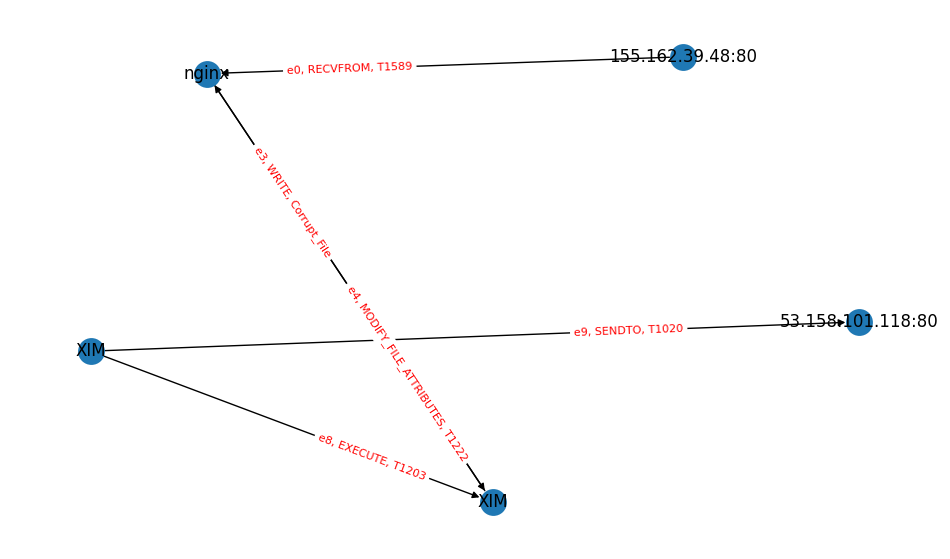

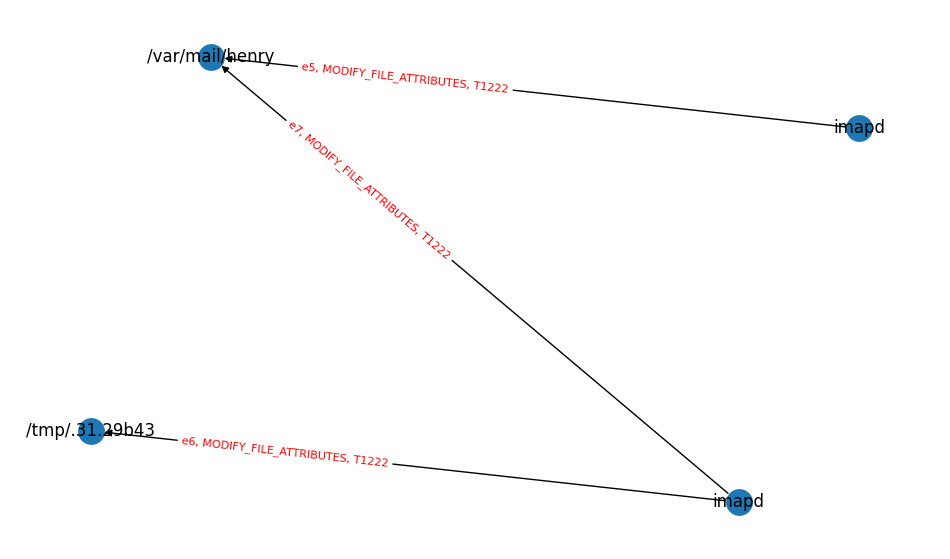

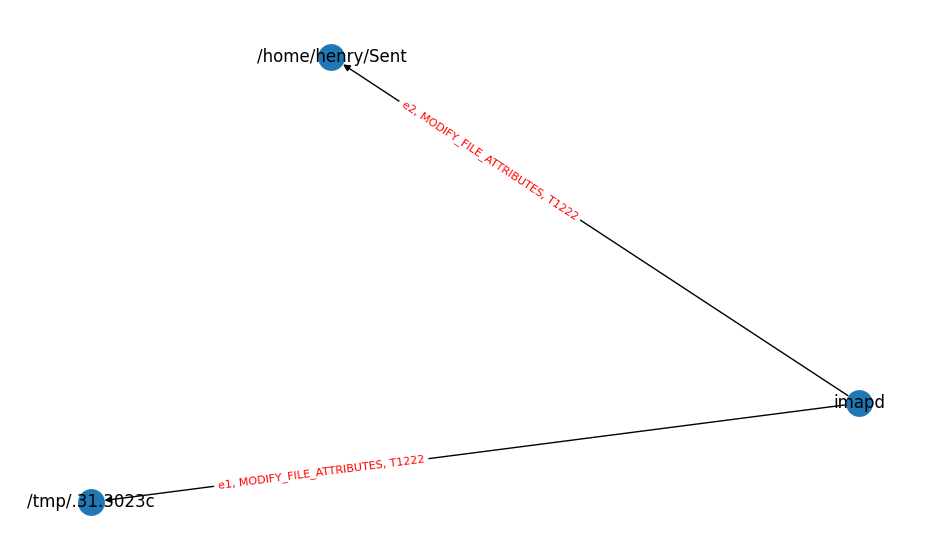

In [25]:
data_for_seq = test_data_for_graph["data_for_sequences"][127] #TP_ls[2]
cur_nodes_ls = data_for_seq['nodes_ls'] 
cur_edges_ls = data_for_seq['edges_ls']


g = nx.DiGraph()  # Creating Directed Graph #MultiDiGraph
# adding nodes and vertices
g.add_nodes_from(cur_nodes_ls)
g.add_edges_from([(edge[0], edge[1]) for edge in cur_edges_ls])
# g.add_edges_from([(edge[1], edge[0]) for edge in cur_edges_ls])
node2label_dict = test_data_for_graph['node2label_dict']

sorted_components = sorted([g.subgraph(subg) for subg in nx.weakly_connected_components(g)], key=len, reverse=True)

for subg in sorted_components:
    fig, ax = plt.subplots(figsize=(12,7))

    pos = nx.spring_layout(subg, k=2000, iterations=2000) #, k=100, iterations=2000

    nx.draw_networkx_nodes(
          subg, pos,
#           node_size=1900,
          linewidths=2,

      )


    nx.draw_networkx_labels(
          subg, pos,
          labels={node_id:node2label_dict[node_id] for node_id in subg.nodes()},
      )

    new_pos = nx.draw_networkx_edges(
          subg, pos,
          label={x:data_for_seq['edge2label_dict'][x] for x in subg.edges()},
          min_source_margin = 10,
          min_target_margin = 10,
          arrows = True, 
#         connectionstyle="arc3, rad = 0.0"
#         connectionstyle="arc"
      )

    n =  nx.draw_networkx_edge_labels(
          subg, pos,
          edge_labels={x:data_for_seq['edge2label_dict'][x] for x in subg.edges()} ,
          font_color='red',
          font_size=8,
#         rotate = False,
#         verticalalignment= 'center_baseline'
          label_pos=0.3,
          # font_weight='bold'
          )

    plt.axis('off')

# nx.draw(g)

Draw FP:

{('219DE547-3E7E-11E8-A5CB-3FA3753A265A2',
  '5026C48F-56BA-3E5B-BA56-DD382B3EC82B2'): Text(-0.602667787175151, 0.7777379270744706, 'e0, EXECUTE, T1203'),
 ('9241BDA8-3F1E-11E8-A5CB-3FA3753A265A',
  '11C64B2C-3DC3-11E8-A5CA-3FA3753A265A'): Text(-0.9140297660208683, -0.20367503575234733, 'e1, RECVFROM, T1589'),
 ('95D7932F-3F1E-11E8-A5CB-3FA3753A265A',
  '11C64B2C-3DC3-11E8-A5CA-3FA3753A265A'): Text(-0.975955784158818, 0.12384931994863757, 'e2, RECVFROM, T1589'),
 ('95D7B680-3F1E-11E8-A5CB-3FA3753A265A',
  '11C64B2C-3DC3-11E8-A5CA-3FA3753A265A'): Text(-0.8172757034791478, -0.2695682721950974, 'e3, RECVFROM, T1589'),
 ('0D4F4D7F-3F1F-11E8-A5CB-3FA3753A265A',
  '05BB325E-8F66-1D59-A68F-361A891D7FC7'): Text(0.8594716206443668, 0.047832660592201676, 'e4, MODIFY_FILE_ATTRIBUTES, T1222'),
 ('0D4F4D7F-3F1F-11E8-A5CB-3FA3753A265A',
  '262049B1-0649-905F-8906-D7486F90FCDD'): Text(0.20379620779223023, -0.9141388296560671, 'e5, MODIFY_FILE_ATTRIBUTES, T1222'),
 ('18C37A5F-3F1F-11E8-A5CB-3FA3753A26

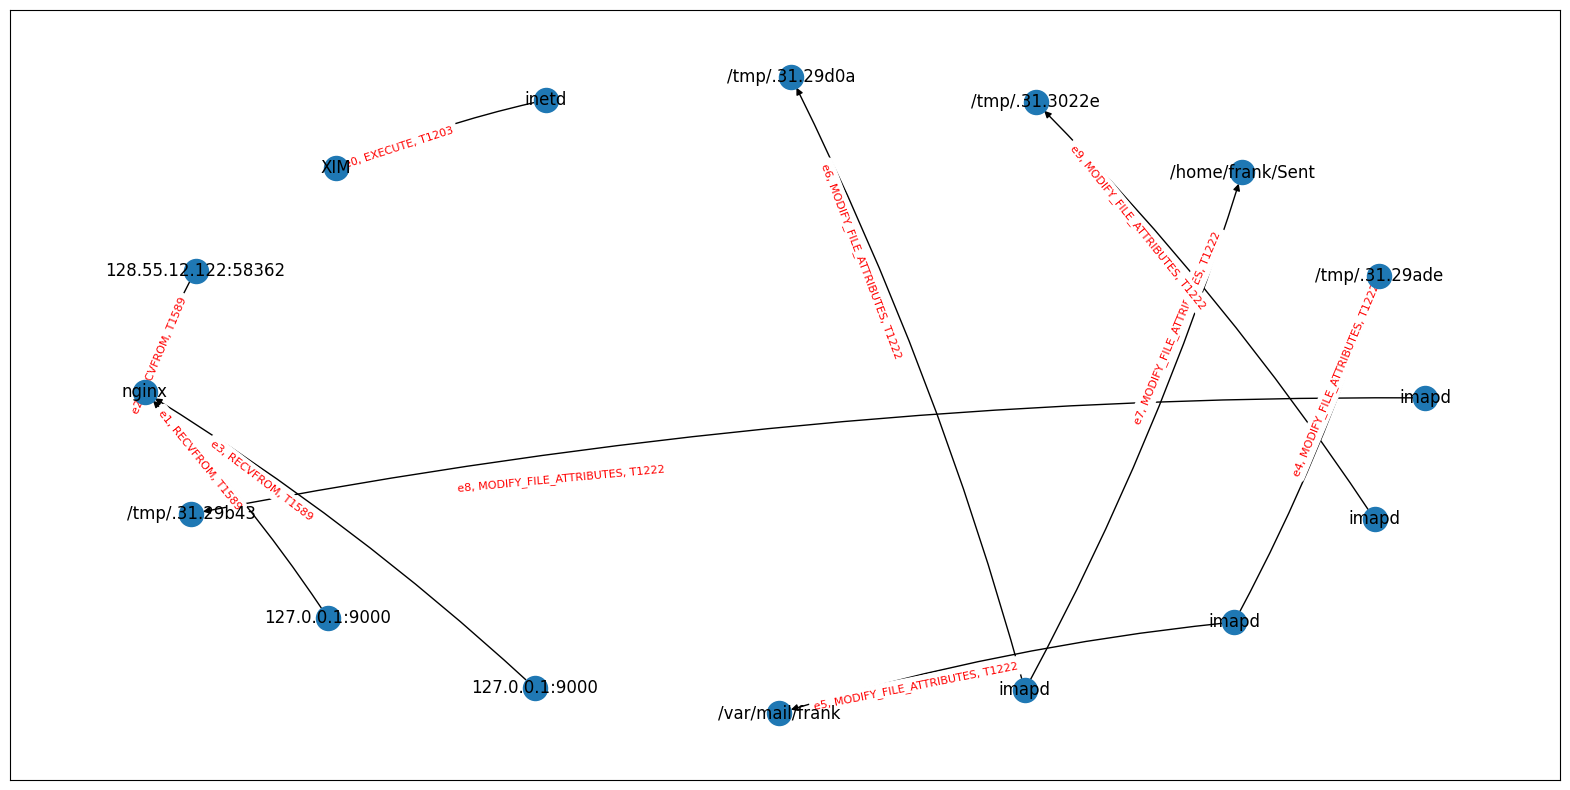

In [26]:
data_for_seq = test_data_for_graph["data_for_sequences"][FP_ls[0]]
cur_nodes_ls = data_for_seq['nodes_ls'] 
cur_edges_ls = data_for_seq['edges_ls']

g = nx.DiGraph()  # Creating Directed Graph #MultiDiGraph
# adding nodes and vertices
g.add_nodes_from(cur_nodes_ls)
g.add_edges_from([(edge[0], edge[1]) for edge in cur_edges_ls])
# g.add_edges_from([(edge[1], edge[0]) for edge in cur_edges_ls])

# nx.draw(g)


fig, ax = plt.subplots(figsize=(20,10))

pos = nx.spring_layout(g, k=200000, iterations=20000) #, k=100, iterations=2000

nx.draw_networkx_nodes(
      g, pos,
      # node_size=300,
      # linewidths=20,

  )

nx.draw_networkx_labels(
      g, pos,
      labels={node_id:node2label_dict[node_id] for node_id in g.nodes()},
  )

node2label_dict = test_data_for_graph['node2label_dict']
nx.draw_networkx_edges(
      g, pos,
      label=data_for_seq['edge2label_dict'],
      min_source_margin = 4,
      min_target_margin = 4,
      arrows = True, connectionstyle="arc3, rad = 0.05"
  )

nx.draw_networkx_edge_labels(
      g, pos,
      edge_labels=data_for_seq['edge2label_dict'] ,
      font_color='red',
      font_size=8,
      label_pos=0.3,
      # font_weight='bold'
      )

Unite alerts:

In [27]:

R = None
for seq_i in TP_ls:
    data_for_seq = test_data_for_graph["data_for_sequences"][seq_i]
    cur_nodes_ls = data_for_seq['nodes_ls'] 
    cur_edges_ls = data_for_seq['edges_ls']
    g = nx.DiGraph()  # Creating Directed Graph #MultiDiGraph
    # adding nodes and vertices
    g.add_nodes_from(cur_nodes_ls)
    g.add_edges_from([(edge[0], edge[1]) for edge in cur_edges_ls])
    g.add_edges_from([(edge[1], edge[0]) for edge in cur_edges_ls])
#     print('TP seq:')
    if not R: 
        R = g.copy()
        continue
#     plt.figure(seq_i)
    R = nx.compose(g, R)
#     nx.draw(g)
    
# sorted_components = sorted([g.subgraph(subg) for subg in nx.weakly_connected_components(g)], key=len, reverse=True)

    
# test_data_for_model['data_for_sequences'][170]['label']

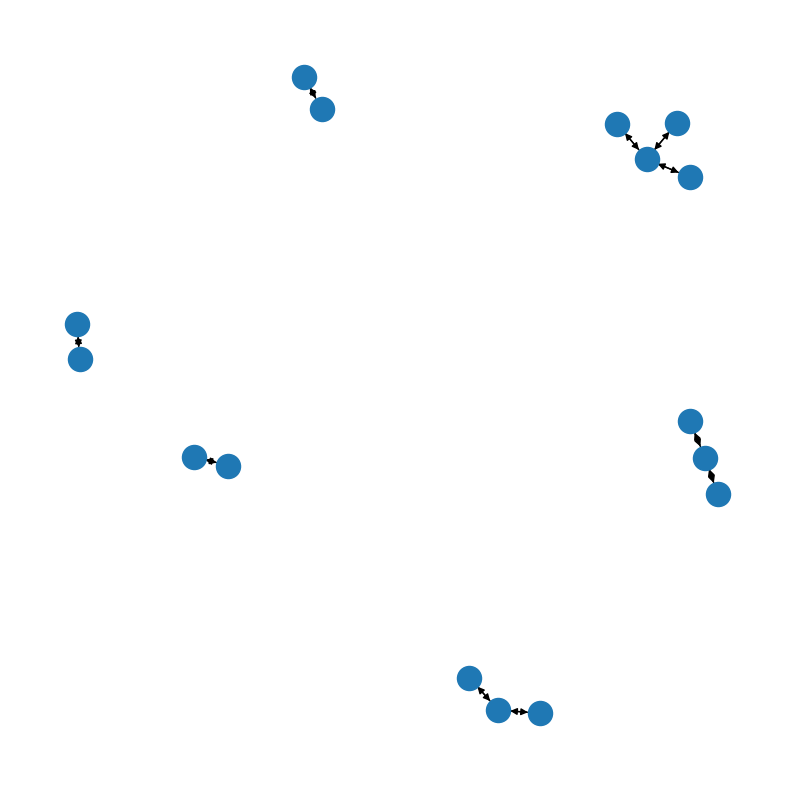

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
# pos = nx.spring_layout(R, k=10) #, k=100, iterations=2000

nx.draw(R)